In [1]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification

In [3]:
import pennylane as qml

In [3]:
def DosLocal(ncubits, theta, reps = 1):
    theta = theta[0]
    for r in range(reps):
        for i in range(ncubits):
            qml.RY(theta[r * ncubits + i], wires = i)
        for i in range(ncubits - 1):
            qml.CNOT(wires = [i, i + 1])
    
    for i in range(ncubits):
        qml.RY(theta[reps * ncubits + i], wires = i)

In [4]:
state_0 = [[1], [0]]
M = state_0 * np.conj(state_0).T

In [5]:
ncubits = 4
reps_fv = 3
dev = qml.device("lightning.qubit", wires = ncubits)
@qml.qnode(dev, interface = "torch")
def nodo(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(ncubits))
    DosLocal(ncubits, weights, reps_fv)
    return qml.expval(qml.Hermitian(M, wires = [0]))

forma_pesos = {"weights": (1,(reps_fv + 1) * ncubits)}
qlayer = qml.qnn.TorchLayer(nodo, forma_pesos)

In [6]:
import torch

import torch.nn as nn
import torch.nn.functional as F


In [7]:
class TorchClassifier(nn.Module):
    
    def __init__(self):
        super(TorchClassifier, self).__init__()
        self.layer1 = nn.Linear(16, 8)
        self.layer2 = nn.Linear(8, 4)
        #self.layer3 = nn.Linear(4, 2)
        #self.layer4 = nn.Linear(2, 1)
        self.layer3_q = qlayer
    
    def forward(self, x):
        x = F.elu(self.layer1(x))
        x = F.elu(self.layer2(x))
        #x = F.elu(self.layer3(x))
        #x = torch.sigmoid(self.layer4(x))
        x = self.layer3_q(x)
        return x

In [8]:
model = TorchClassifier()
print(model)

TorchClassifier(
  (layer1): Linear(in_features=16, out_features=8, bias=True)
  (layer2): Linear(in_features=8, out_features=4, bias=True)
  (layer3_q): <Quantum Torch Layer: func=nodo>
)


In [9]:
model(torch.rand(16))

tensor(0.3601, grad_fn=<ExecuteTapesBackward>)

In [10]:
x, y = make_classification(n_samples = 1000, n_features = 16)

x_tr, x_test, y_tr, y_test = train_test_split(
    x, y, train_size = 0.8)
x_val, x_test, y_val, y_test = train_test_split(
    x_test, y_test, train_size = 0.5)

In [11]:
from torch.utils.data import Dataset

class NumpyDataset(Dataset):
    def __init__(self, x, y):
        
        if (x.shape[0] != y.shape[0]):
            raise Exception("incompatible arrays")
        
        y = y.reshape(-1,1)
        
        self.x = torch.from_numpy(x).to(torch.float)
        self.y = torch.from_numpy(y).to(torch.float).squeeze()
        
    def __getitem__(self, i):
        return self.x[i], self.y[i]
    
    def __len__(self):
        return self.y.shape[0]

In [12]:
tr_data = NumpyDataset(x_tr, y_tr)
val_data = NumpyDataset(x_val, y_val)
test_data = NumpyDataset(x_test, y_test)

In [13]:
print(tr_data[0])
print("Length:", len(tr_data))

(tensor([ 1.1893, -0.7450, -0.9382,  0.4481,  1.5550, -1.2233,  0.6847, -1.6614,
        -1.2671, -1.9509, -0.0592, -0.0192, -0.0771,  0.2434, -0.8407, -1.2386]), tensor(0.))
Length: 800


In [14]:
from torch.utils.data import DataLoader
tr_loader = iter(DataLoader(tr_data, batch_size = 2, shuffle = True))
print(next(tr_loader))

[tensor([[ 2.0672, -1.2256, -0.4668,  0.2553,  2.7429, -2.2331,  2.6908, -2.8643,
          0.0158,  0.0477,  0.0512, -0.3943,  0.6104, -0.5561, -0.2447, -0.5182],
        [ 0.4905, -0.3883, -0.3591,  1.2956,  0.5947, -0.4566,  0.2989, -0.7129,
         -0.3024,  0.8290,  0.1374, -0.0526, -0.5877, -1.4889, -0.0811,  0.9277]]), tensor([0., 1.])]


In [15]:
get_loss = F.binary_cross_entropy

In [16]:
print(get_loss(torch.tensor([1.]), torch.tensor([1.])))

tensor(0.)


In [17]:
tr_loader = DataLoader(tr_data, batch_size = 100, shuffle = True)
opt = torch.optim.Adam(model.parameters(), lr = 0.005)

In [18]:
def run_epoch(opt, tr_loader):
    for data in iter(tr_loader):
        x, y = data
        opt.zero_grad()
        loss = get_loss(model(x), y)
        loss.backward()
        opt.step()

    return get_loss(model(tr_data.x), tr_data.y).detach()

In [19]:
tr_losses = []
val_losses = []

In [20]:
while len(val_losses) < 2 or val_losses[-1] < val_losses[-2]:
    print("EPOCH", len(tr_losses) + 1, end = " ")
    tr_losses.append(float(run_epoch(opt, tr_loader)))
    val_losses.append(float(get_loss(model(val_data.x), val_data.y).detach()))
    print("| Train loss:", round(tr_losses[-1],4), end = " ")
    print("| Valid loss:", round(val_losses[-1],4))

EPOCH 1 | Train loss: 0.6888 | Valid loss: 0.6988
EPOCH 2 | Train loss: 0.659 | Valid loss: 0.6627
EPOCH 3 | Train loss: 0.6199 | Valid loss: 0.6227
EPOCH 4 | Train loss: 0.561 | Valid loss: 0.5647
EPOCH 5 | Train loss: 0.4818 | Valid loss: 0.4898
EPOCH 6 | Train loss: 0.4021 | Valid loss: 0.4169
EPOCH 7 | Train loss: 0.3417 | Valid loss: 0.3596
EPOCH 8 | Train loss: 0.3004 | Valid loss: 0.3202
EPOCH 9 | Train loss: 0.2717 | Valid loss: 0.3004
EPOCH 10 | Train loss: 0.2511 | Valid loss: 0.2853
EPOCH 11 | Train loss: 0.2349 | Valid loss: 0.2722
EPOCH 12 | Train loss: 0.2221 | Valid loss: 0.2645
EPOCH 13 | Train loss: 0.212 | Valid loss: 0.2596
EPOCH 14 | Train loss: 0.2037 | Valid loss: 0.2586
EPOCH 15 | Train loss: 0.1968 | Valid loss: 0.256
EPOCH 16 | Train loss: 0.1911 | Valid loss: 0.2558
EPOCH 17 | Train loss: 0.1865 | Valid loss: 0.2542
EPOCH 18 | Train loss: 0.1831 | Valid loss: 0.25
EPOCH 19 | Train loss: 0.1802 | Valid loss: 0.2571


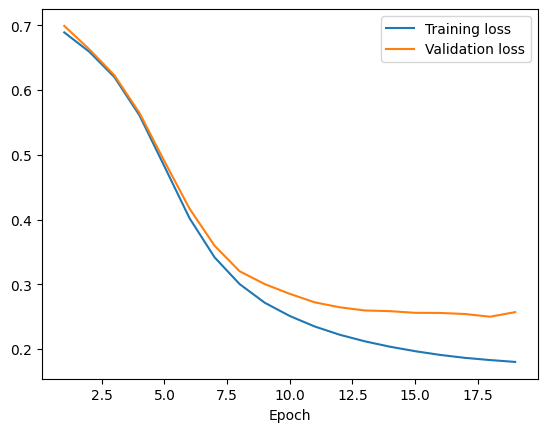

In [21]:
import matplotlib.pyplot as plt
def plot_losses(tr_loss, val_loss):
    epochs = np.array(range(len(tr_loss))) + 1
    plt.plot(epochs, tr_loss, label = "Training loss")
    plt.plot(epochs, val_loss, label = "Validation loss")
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()

plot_losses(tr_losses, val_losses)

In [22]:
train_acc = accuracy_score(
    (model(tr_data.x) >= 0.5).to(float), tr_data.y)
val_acc = accuracy_score(
    (model(val_data.x) >= 0.5).to(float), val_data.y)
test_acc = accuracy_score(
    (model(test_data.x) >= 0.5).to(float), test_data.y)
print("Training accuracy:", train_acc)
print("Validation accuracy:", val_acc)
print("Test accuracy:", test_acc)

Training accuracy: 0.95
Validation accuracy: 0.91
Test accuracy: 0.94
